In [2]:
## Importing Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, AncillaRegister, Aer, execute
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator
from qiskit.circuit.library import MCMT, RYGate
import numpy as np
np.set_printoptions(threshold=np.inf)
import math
from typing import Union

In [158]:
## Settings
d = 1 # of dimensions
M = 1 # of registers (rough estimate for M is the number of particles in the final state, but M should be set so that p_success can be maximized)
n = 1 # of particles in the initial state
N_abs = 3 # of modes for momenta
m = 1 # mass of particles of projectile
tau_0 = 1 # time for free field
M_step = 100
tau_I = 1 # time for interaction time

N_s = 2 ** (N_abs + 1) # size of the lattice per one dimension
V = N_s ** d # volume
N = N_abs * d + d + 1 # of qubits per one particle (magnitude of momentum + sign + occupation)
s = math.ceil(math.log2(math.factorial(M)/math.factorial(M - n))) # of ancilla qubits for Bose symm.
delta_0 = tau_0 /  M_step

In [137]:
def init(M, N_abs, d): # initialize circuit
    N = N_abs * d + d + 1
    particle_registers = []
    for i in range(M):
        particle_registers.append(QuantumRegister(N, name = f'particle{i}'))
    ancilla_register_h0 = AncillaRegister((N_abs + math.log2(n)) * d, name = f'aux_H0') # aux registers for free Hamiltonian
    ancilla_register_symm = AncillaRegister(s + 1, name = f'aux_Bose') # aux registers for Bose symmetrization
    ancilla_increment = AncillaRegister(1, name = 'aux_incre')
    classical_register_symm = ClassicalRegister(1, name = 'cla_Bose')
    circuit = QuantumCircuit(*particle_registers, ancilla_register_h0, ancilla_register_symm, ancilla_increment, classical_register_symm)
    particle_1D_list = [element for sublist in particle_regs for element in sublist]
    return circuit, particle_registers, ancilla_register_h0, ancilla_register_symm, ancilla_increment, classical_register_symm, particle_1D_list

circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
# circuit.draw('mpl')

In [5]:
## exponential wave packet で局在化
def expWavePacket(particle_reg):
    wave_circ = QuantumCircuit(particle_reg)
    wave_circ.x(particle_reg[N_abs * d + d])
    wave_circ.h(particle_reg[N_abs * d : N_abs * d + d])
    for iqubit in range(N_abs * d):
        sigma = 1
        theta = math.atan(math.exp(- 2 ** (iqubit - 1) / sigma))
        wave_circ.ry(2 * theta, particle_reg[iqubit])
    wave_gate = wave_circ.to_gate()
    return wave_gate

In [6]:
## exponential wave packet で局在化
def preWavePacket(particle_reg):
    wave_circ = QuantumCircuit(particle_reg)
    wave_circ.x(particle_reg[N_abs * d + d])
    wave_circ.h(particle_reg[N_abs * d : N_abs * d + d])
    for iqubit in range(N_abs * d):
        eps = 0.15 # pがガウシアンになるように調整する必要あり
        theta_lin = np.pi / 4 - eps + ((2 * eps - np.pi / 4) / (N_abs - 1)) * (iqubit % N_abs) # 論文のAppendixのtheta_linear
        wave_circ.ry(2 * theta_lin, particle_reg[iqubit])
    gauss_gate = wave_circ.to_gate()
    return gauss_gate

In [7]:
# function of Quantum Fourier Transformation
def qFT(num):
    qft_circuit = QuantumCircuit(num)
    for iqubit in range(num - 1, -1, -1):
        qft_circuit.h(iqubit)
        for ictrl in range(iqubit - 1, -1, -1):
            dphi = 2 * np.pi / (2 ** num)
            power = 2 ** (ictrl - iqubit - 1 + num)
            phi = power * dphi
            qft_circuit.cp(phi, ictrl, iqubit)
    for iswap in range(num // 2):
        qft_circuit.swap(iswap, num-1-iswap)
    qft_circuit.to_gate()
    return qft_circuit

# function of inverse Quantum Fourier Transformation
def invQFT(num):
    inv_qft_circuit = QuantumCircuit(num)
    for iswap in range(num // 2):
        inv_qft_circuit.swap(iswap, num-1-iswap)
    for iqubit in range(num):
        for ictrl in range(iqubit):
            dphi = 2 * np.pi / (2 ** num)
            power = 2 ** (ictrl - iqubit -1 + num)
            phi = dphi * power
            inv_qft_circuit.cp(-phi, ictrl, iqubit)
        inv_qft_circuit.h(iqubit)
    inv_qft_circuit.to_gate()
    return inv_qft_circuit

In [8]:
def translateGate(trans_mat, particle_reg, flag): # flag==1 means position translation and flag==0 means momentum translation
    trans_circuit = QuantumCircuit(particle_reg)
    if flag == 1:
        sign = 1
    elif flag == 0:
        sign = -1
    else: print('flag should be true or not!')
    for iqubit in range(N_abs * d + d): # 量子レジスタ内のiqubit番目の量子ビットを考える
        trans_circuit.p((-2 * np.pi * sign * (2 ** iqubit) * trans_mat) / 2 ** (N_abs + 1), particle_reg[iqubit])
    trans_gate = trans_circuit.to_gate()
    return trans_gate

In [9]:
def changeBasis(particle_reg):
    basis_circuit = QuantumCircuit(particle_reg)
    basis_circuit.x(particle_reg[N_abs])
    for iqubit in range(N_abs):
        basis_circuit.ccx(particle_reg[N_abs], particle_reg[N_abs+1], particle_reg[iqubit])
    basis_circuit.x(particle_reg[N_abs])
    basis_gate = basis_circuit.to_gate()
    return basis_gate

In [10]:
def checkBoseSymm(circuit, anc_reg_symm):
    circuit.mcx(anc_reg_symm[:s], anc_reg_symm[s])
    circuit.measure(anc_reg_symm[s], 0)
    # check the value of the classical bit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(circuit, simulator)
    job = execute(compiled_circuit, simulator, shots=1)  # シミュレーションを実行

    result = job.result()
    counts = result.get_counts(circuit)

    # 1つの量子ビットの値を取得
    for key in counts:
        measured_bit = int(key, 2)
        print(f"測定された量子ビットの値: {measured_bit}")
        if measured_bit == 1:
            print('Fail...')
        else: print('Success!')
    return measured_bit

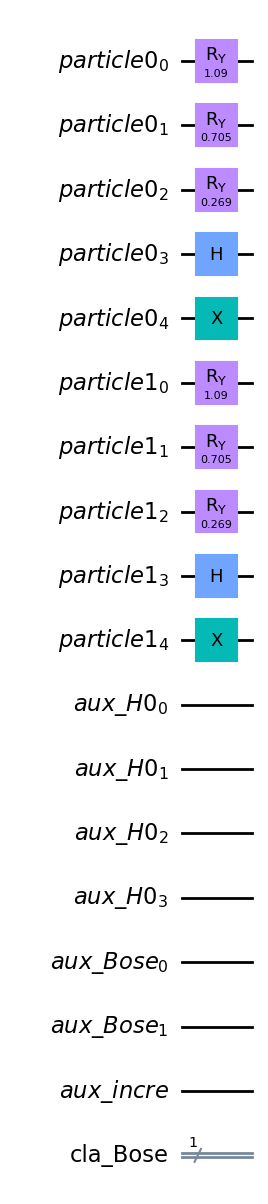

In [138]:
#### A. Initial State Preparation ####
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
## 初期状態において, 粒子がある量子レジスタのインデックスのリストを用意する
## 第0量子レジスタに粒子があると仮定
# ボース対称化するので, 第0量子レジスタから順に第n(=入射粒子数)量子レジスタまで粒子を詰めていく

## Gaussian(には現在なっていない) wave packet で局在化
for ireg in range(n):
    # gauss_gate = preWavePacket(particle_regs[ireg])
    wave_packet_gate = expWavePacket(particle_regs[ireg])
    wave_packet_gate.name = f'{ireg}th wave packet'
    circuit.append(wave_packet_gate, qargs=particle_regs[ireg][:])

circuit.decompose().draw('mpl')

In [12]:
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
circuit.barrier()

pos_trans_mat = np.zeros((n, d))
pos_trans_mat[0][0] = 0 # 第0量子レジスタの第0次元に存在する粒子をhogehogeマス移動
pos_trans_mat[1][0] = 4

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

## translation
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(pos_trans_mat[ireg][idim], particle_regs[ireg], True)
        trans_gate.name = f'{ireg}th position trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# you can check wheter wavepackets translate correctly
# qft_gate = qFT(len(particle_regs[0][:N_abs+1]))
# qft_gate.name = 'QFT'
# circuit.append(qft_gate, qargs=particle_regs[0][:N_abs+1])

# circuit.draw('mpl')

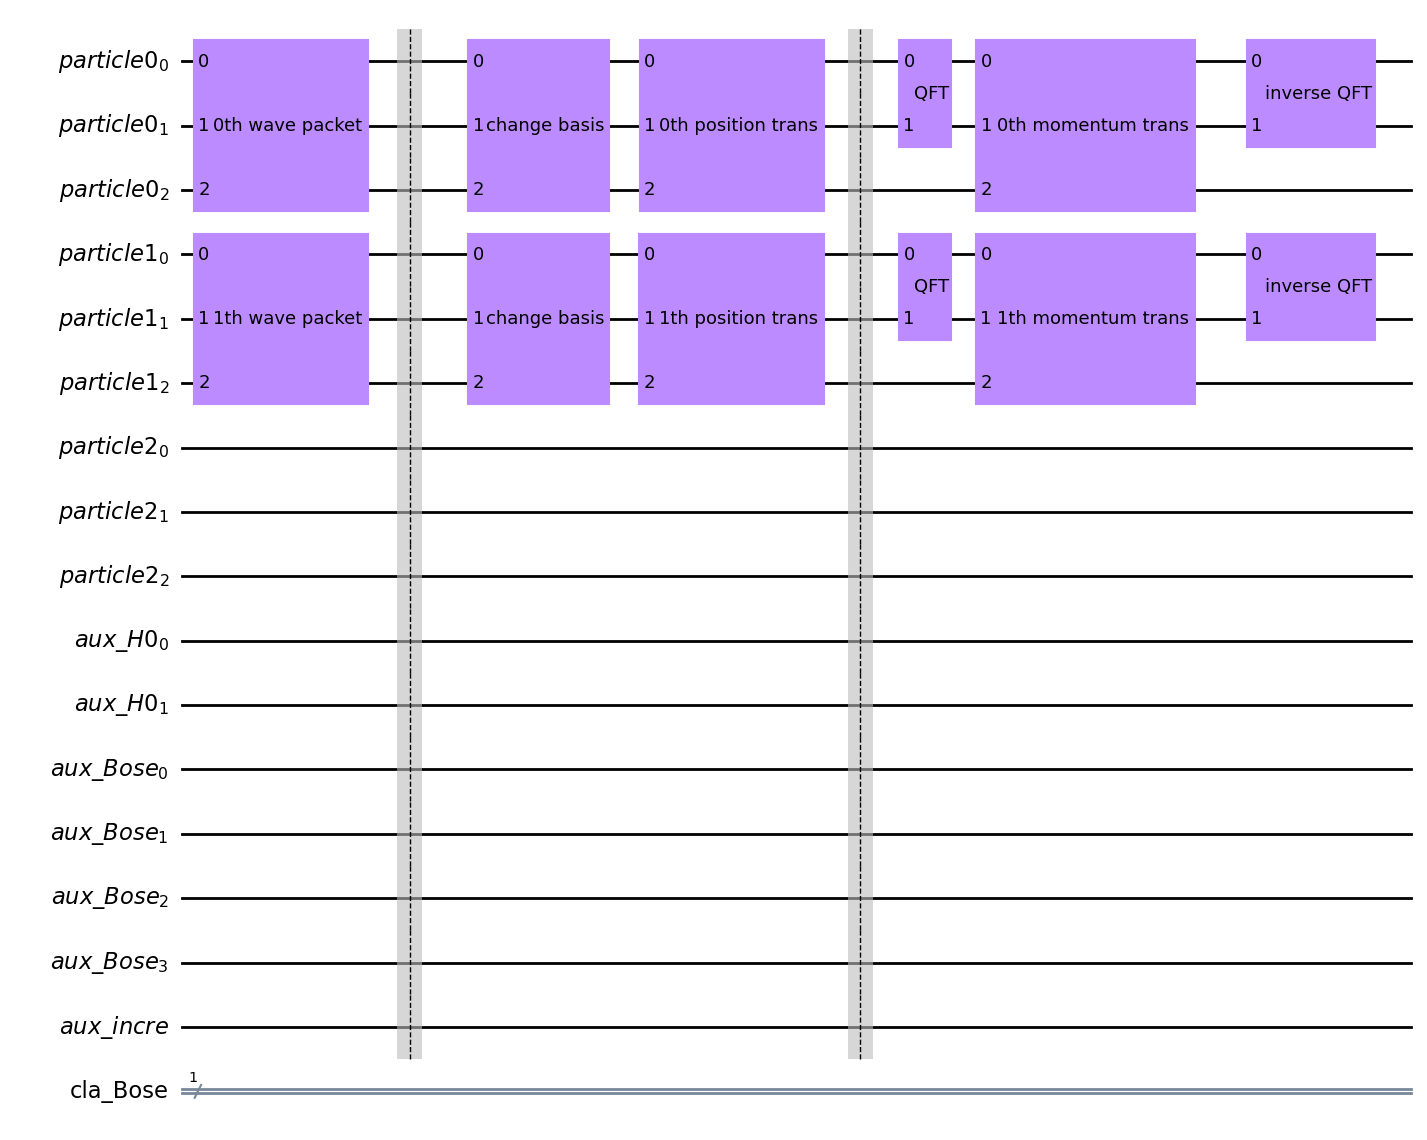

In [13]:
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
circuit.barrier()

for ireg in range(n):
    qft_gate = qFT(particle_regs[ireg].size-1)
    qft_gate.name = 'QFT'
    circuit.append(qft_gate, qargs=particle_regs[ireg][:N-1])

## 波束の運動量空間の重心 pbar を並進移動させる
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 1 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心をhogehogeマス移動
mom_trans_mat[1][0] = -1

## translation
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(mom_trans_mat[ireg][idim], particle_regs[ireg], False)
        trans_gate.name = f'{ireg}th momentum trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# inverse symmetric QFT
for ireg in range(n):
    inv_qft_gate = invQFT(particle_regs[ireg].size-1)
    inv_qft_gate.name = 'inverse QFT'
    circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:N-1])
    # basis_change_gate = changeBasis(particle_regs[ireg])
    # basis_change_gate.name = 'change basis'
    # circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

# circuit.decompose().draw('mpl')
circuit.draw('mpl')

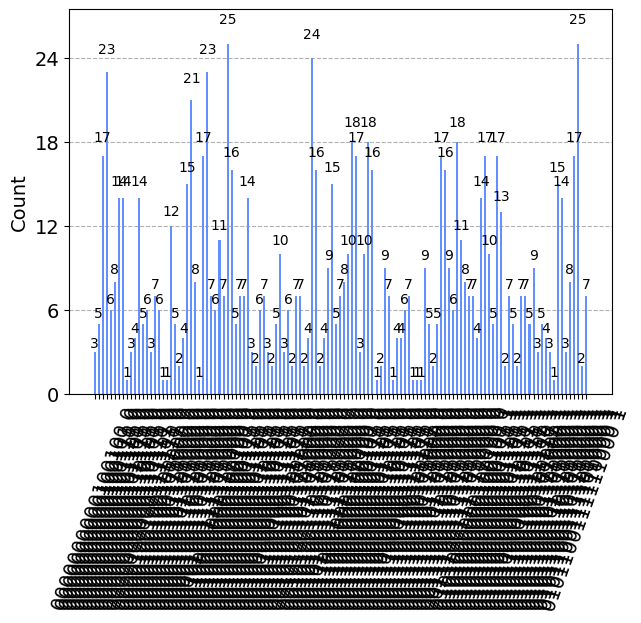

In [15]:
## how to measure and count
circuit.measure_all()
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

# plot y axis logarithmically
# log_data = {key: np.log10(value + 1) for key, value in counts.items()}
# # プロット
# plot_histogram(log_data, bar_labels=False)

In [ ]:
# ## Bose symmetrization (M=2, n=1)

# circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(3, N_abs, d)
# # n, Mに応じて改訂する必要あり
# circuit.h(anc_reg_symm[:s])
# for ireg in range(M):
#     for jreg in range(M):
#         for iqubit in range(N):
#             if ireg > jreg:
#                 circuit.cswap(anc_reg_symm[0], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
# # circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？

# circuit.cx(particle_regs[1][N - 1], anc_reg_symm[:s])

In [ ]:
## Bose symmetrization (M=3, n=2)
circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(3, N_abs, d)
# n, Mに応じて改訂する必要あり
circuit.h(anc_reg_symm[:s])
for ireg in range(M):
    for jreg in range(M):
        for iqubit in range(N):
            if ireg > jreg:
                circuit.cswap(anc_reg_symm[0], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
# circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？

# for |1,1,0>
circuit.x(anc_reg_symm[s-1])
measured_bit = checkBoseSymm(circuit, anc_reg_symm)
circuit.x(anc_reg_symm[s-1])

# for |0,1,0>
circuit.x(anc_reg_symm[0])
circuit.x(anc_reg_symm[s-1])
measured_bit = checkBoseSymm(circuit, anc_reg_symm)
circuit.x(anc_reg_symm[0])
circuit.x(anc_reg_symm[s-1])

circuit.draw('mpl')

In [150]:
def phiAdditionGate(dphi, particle_regs, anc_reg_h0):
    phi_add_circuit = QuantumCircuit(*particle_regs, anc_reg_h0)
    phi_add_circuit.h(anc_reg_h0) # equal superposition
    # addition
    for reg_ctrl in particle_regs:
        for ictrl, qctrl in enumerate(reg_ctrl[0:N_abs * d]):
            for itarg, qtarg in enumerate(anc_reg_h0):
                phi_add_circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
    phi_add_gate = phi_add_circuit.to_gate()
    return phi_add_gate

def uncomputePhiGate(dphi, particle_regs, anc_reg_h0):
    uncompute_circuit = QuantumCircuit(*particle_regs, anc_reg_h0)
    # addition
    for reg_ctrl in particle_regs:
        for ictrl, qctrl in enumerate(reg_ctrl[0:N_abs * d]):
            for itarg, qtarg in enumerate(anc_reg_h0):
                uncompute_circuit.cp(- dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
    uncompute_circuit.h(anc_reg_h0) # unsolve equal superposition
    uncompute_gate = uncompute_circuit.to_gate()
    return uncompute_gate

In [59]:
# |phi>|q1>|q2>...という状態なので, S_phiを構成するゲートを作る（普通のゲートと制御ゲートを作る）
def sPhiGate(anc_reg_h0, M, delta_0):
    s_circuit = QuantumCircuit(anc_reg_h0)
    for ianc, qanc in enumerate(anc_reg_h0):
        dphi = -delta_0 / M
        s_circuit.p(dphi * (2 ** ianc), qanc)
    s_gate = s_circuit.to_gate()
    cs_gate = s_gate.control(1)
    cs_gate.name = 'Cphi gate'
    return s_gate, cs_gate

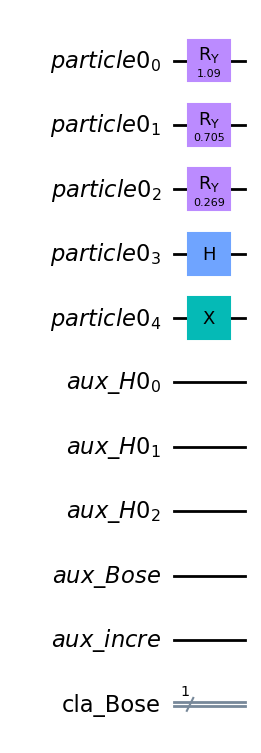

In [171]:
#### A. Initial State Preparation ####
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
## 初期状態において, 粒子がある量子レジスタのインデックスのリストを用意する
## 第0量子レジスタに粒子があると仮定
# ボース対称化するので, 第0量子レジスタから順に第n(=入射粒子数)量子レジスタまで粒子を詰めていく

## Gaussian(には現在なっていない) wave packet で局在化
for ireg in range(n):
    # gauss_gate = preWavePacket(particle_regs[ireg])
    wave_packet_gate = expWavePacket(particle_regs[ireg])
    wave_packet_gate.name = f'{ireg}th wave packet'
    circuit.append(wave_packet_gate, qargs=particle_regs[ireg][:])

circuit.decompose().draw('mpl')

In [168]:
particle_regs
particle_1D_list

[Qubit(QuantumRegister(5, 'particle0'), 0),
 Qubit(QuantumRegister(5, 'particle0'), 1),
 Qubit(QuantumRegister(5, 'particle0'), 2),
 Qubit(QuantumRegister(5, 'particle0'), 3),
 Qubit(QuantumRegister(5, 'particle0'), 4)]

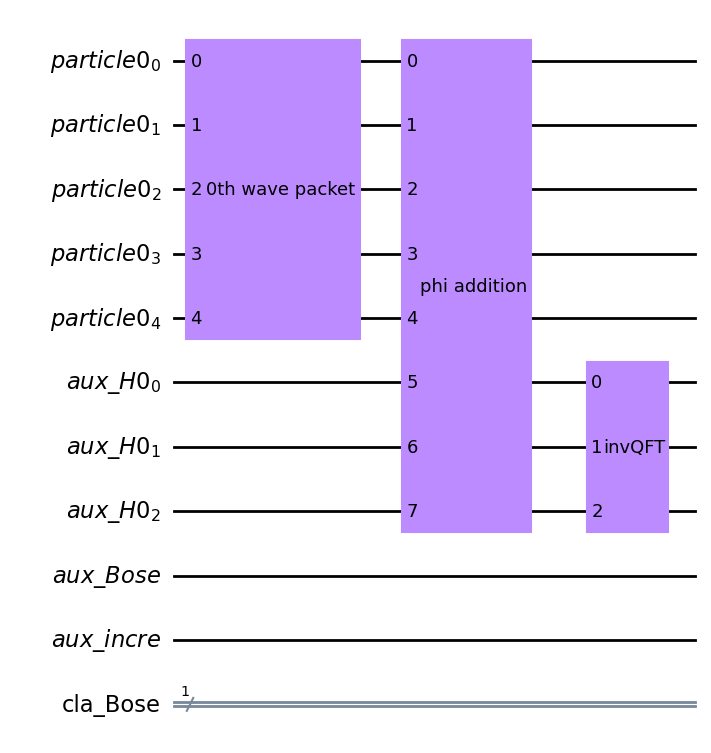

In [172]:
#### B. Time Evolution ####
## Free Hamiltonian ##

# circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
# circuit.x(particle_regs[0][0])
# circuit.x(particle_regs[0][1])
# circuit.x(particle_regs[0][2])
# circuit.x(particle_regs[1][0])
# circuit.x(particle_regs[1][1])
# circuit.x(particle_regs[1][2])

# l0 = anc_reg_h0.size
dphi = 2 * np.pi / (2 ** anc_reg_h0.size)

phi_add_gate = phiAdditionGate(dphi, particle_regs, anc_reg_h0)
phi_add_gate.name = 'phi addition'
circuit.append(phi_add_gate, qargs=particle_1D_list + anc_reg_h0[:])
# inverse QFT
inv_qft_gate = invQFT(len(anc_reg_h0[:]))
inv_qft_gate.name = 'invQFT'
circuit.append(inv_qft_gate, qargs=anc_reg_h0[:])

circuit.draw('mpl')

In [173]:
circuit.barrier()
s_gate, cs_gate = sPhiGate(anc_reg_h0, M, 10000)
s_gate.name = 'Sphi gate'
cs_gate.name = 'Cphi gate'
circuit.append(s_gate, qargs=anc_reg_h0)
for iregs in range(M):
    circuit.x(particle_regs[iregs][N - 1])
    cs_gate.name = 'Sphi gate'
    circuit.append(cs_gate, qargs=([particle_regs[iregs][N - 1]] + anc_reg_h0[:])) # n_omegaの数だけS_phiを作用
    circuit.x(particle_regs[iregs][N - 1])
# circuit.draw('mpl')
# phiをuncomputeする必要あり？

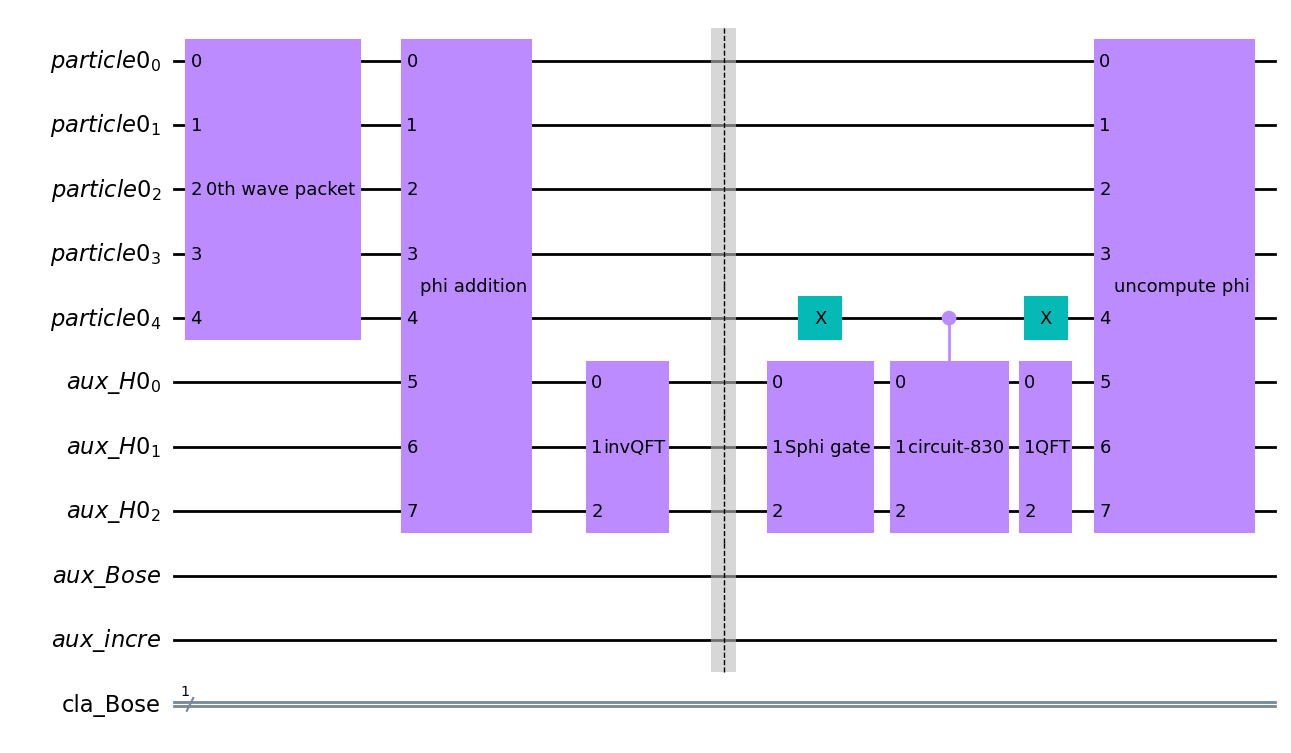

In [174]:
# uncompute phi ancilla qubits
# QFT
qft_gate = qFT(len(anc_reg_h0[:]))
qft_gate.name = 'QFT'
circuit.append(qft_gate, qargs=anc_reg_h0[:])

uncompute_gate = uncomputePhiGate(dphi, particle_regs, anc_reg_h0)
uncompute_gate.name = 'uncompute phi'
circuit.append(uncompute_gate, qargs=particle_1D_list + anc_reg_h0[:])

circuit.draw('mpl')

In [175]:
## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

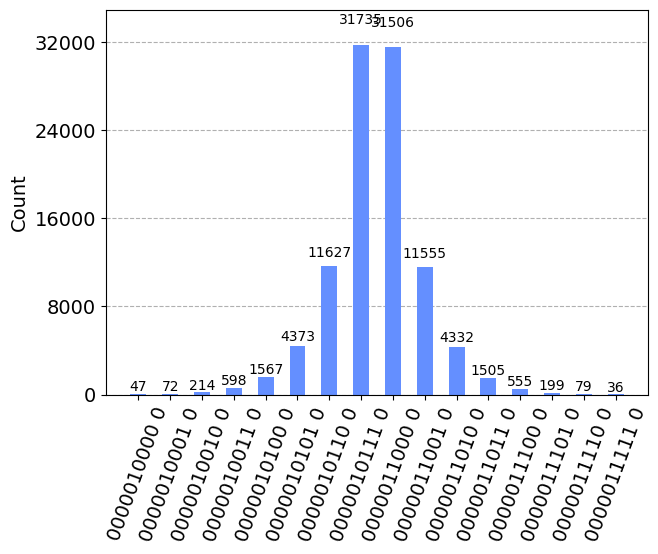

In [176]:
## how to measure and count
circuit.measure_all()
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=100000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

In [13]:
#### Squeezing transformation ####

In [14]:
def increGate(reg_size):
    inc_num = reg_size
    inc_circuit = QuantumCircuit(inc_num + 1)
    inc_circuit.x(inc_num)
    for iqubit in range(inc_num):
        inc_circuit.cx(inc_num, iqubit)
        if iqubit > 0:
            inc_circuit.x(range(iqubit))
        if iqubit == inc_num - 1:
            inc_circuit.x(inc_num - 1)
            inc_circuit.x(inc_num)
        inc_circuit.mcx(list(range(iqubit + 1)), inc_num)
        if iqubit > 0:
            inc_circuit.x(range(iqubit))
        if iqubit == inc_num - 1:
            inc_circuit.x(inc_num - 1)
            inc_circuit.x(inc_num)
    inc_gate = inc_circuit.to_gate()
    return inc_gate

def invIncreGate(reg_size):
    inv_inc_num = reg_size
    inv_inc_circuit = QuantumCircuit(inv_inc_num + 1)
    for iqubit in range(inv_inc_num - 1, -1, -1):
        if iqubit > 0:
            inv_inc_circuit.x(range(iqubit))
        if iqubit == inv_inc_num - 1:
            inv_inc_circuit.x(inv_inc_num - 1)
            inv_inc_circuit.x(inv_inc_num)
        inv_inc_circuit.mcx(list(range(iqubit + 1)), inv_inc_num)
        if iqubit > 0:
            inv_inc_circuit.x(range(iqubit))
        if iqubit == inv_inc_num - 1:
            inv_inc_circuit.x(inv_inc_num - 1)
            inv_inc_circuit.x(inv_inc_num)
        inv_inc_circuit.cx(inv_inc_num, iqubit)
    inv_inc_circuit.x(inv_inc_num)
    inv_inc_gate = inv_inc_circuit.to_gate()
    return inv_inc_gate


In [54]:
# example and visualization of inverse increment operation
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
# inv_inc_gate= invIncreGate(particle_regs[0].size)
# circuit.x(particle_regs[1][1])
# circuit.append(inv_inc_gate, qargs=particle_regs[1][:] + [anc_incre])
# circuit.decompose().draw('mpl')
# circuit.draw('mpl')

In [55]:
# example and visualization of increment operation
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
# inc_gate= increGate(particle_regs[0].size)
# circuit.x(particle_regs[1])
# circuit.append(inc_gate, qargs=particle_regs[1][:] + [anc_incre])
# circuit.decompose().draw('mpl')

In [15]:
# 全ての運動量モード、全てのレジスタのパターンに対してSqijを考える
def squeeze(qmode, ireg, jreg): # まだ実装中
    zq = 0.5 * math.log2(qmode + 1/2)
    nfrak = 2 * ireg.size
    reg_list = [ireg, jreg]
    ancilla = AncillaRegister(1)
    sq_circuit = QuantumCircuit(*reg_list, ancilla)
    modebits = bin(qmode)[2:]

    for ibit in range(N_abs): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(modebits) > ibit:
            if int(modebits[-(ibit+1)]) == 0:
                sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])
        else:
            sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
            sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])
    sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[N_abs])

    inv_inc_gate = invIncreGate(nfrak)
    inv_inc_gate.name = 'inv increment gate'
    sq_circuit.append(inv_inc_gate, qargs=ireg[:] + jreg[:] + ancilla[:])

    sq_circuit.x(ireg[:] + jreg[:jreg.size-1])
    mcry = MCMT(RYGate(zq/M), 2 * jreg.size - 1, 1)
    sq_circuit.append(mcry.decompose(), qargs=ireg[:]+jreg[:jreg.size-1] + [jreg[jreg.size-1]])
    # sq_circuit.cry((zq/M), ireg[:]+jreg[:jreg.size-1], jreg[jreg.size-1]) # controlled gate　ってこれであってる？
    sq_circuit.x(ireg[:] + jreg[:jreg.size-1])

    inc_gate = increGate(nfrak)
    inc_gate.name = f'increment gate'
    sq_circuit.append(inc_gate, qargs=ireg[:] + jreg[:] + ancilla[:])

    for ibit in range(N_abs): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(modebits) > ibit:
            if int(modebits[-(ibit+1)]) == 0:
                sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])
        else:
            sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
            sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])
    sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[N_abs])
    
    # reverse states
    # for ibit in range(modebits):
    #     targ_bit = int(bin(qmode)[2 + ibit])
    #     sq_circuit.cx(ireg[N_abs+1], ireg[targ_bit])
    #     sq_circuit.cx(jreg[N_abs+1], jreg[targ_bit])
    #     sq_circuit.cx(jreg[N_abs + d - 1], jreg[targ_bit]) # because flip sign qubit of jth particle register
    return sq_circuit, modebits

In [68]:
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)

# reg_size = particle_regs[0].size
# mcry = MCMT(RYGate(np.pi/M), 2 * reg_size - 1, 1)
# circuit.append(mcry, qargs=particle_regs[0][:]+particle_regs[1][:reg_size-1] + [jreg[reg_size-1]])
# circuit.decompose().draw('mpl')

In [ ]:
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)

for imode in range(2 ** N_abs):
    for inum, ireg in enumerate(particle_regs):
        for jnum, jreg in enumerate(particle_regs):
            if inum != jnum:
                # print('imode =',imode)
                # print(ireg)
                # print(jreg)
                sq_gate, modebit = squeeze(imode, ireg, jreg)
                # print('modebit =',modebit)
                sq_gate.name = f'mode{imode} sq'
                circuit.append(sq_gate, qargs=ireg[:] + jreg[:] + anc_incre[:])
                circuit.barrier()

circuit.decompose().draw('mpl')
# circuit.draw('mpl')

In [ ]:
# symmetric QFT
for ireg in range(M):
    change_gate = changeBasis(particle_regs[ireg])
    change_gate.name = 'change basis'
    circuit.append(change_gate, qargs=particle_regs[ireg][:])
    qft_gate =qFT(particle_regs[ireg].size)
    qft_gate.name = 'QFT'
    circuit.append(qft_gate, qargs=particle_regs[ireg][:])

circuit.draw('mpl')

In [ ]:
# # Show the state vector
# simulator = AerSimulator(method='statevector')
# circuit.save_statevector()
# circuit = transpile(circuit, backend=simulator)
# statevector = np.asarray(simulator.run(circuit).result().data()['statevector'])
# print(statevector)

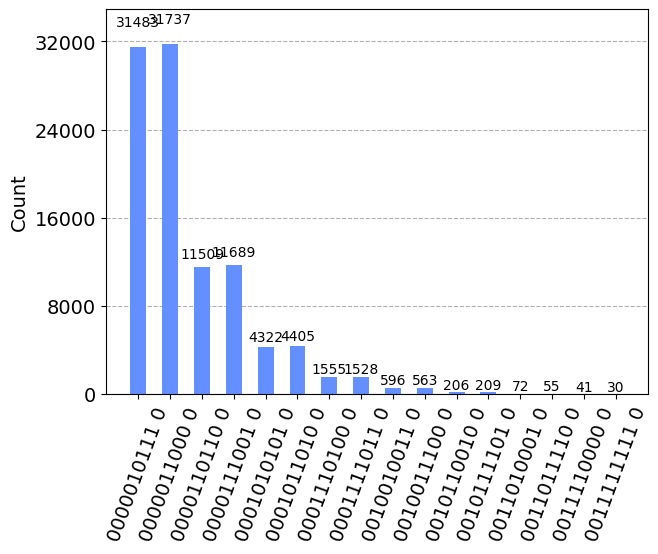

In [51]:
## how to measure and count
circuit.measure_all()
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=100000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

# plot y axis logarithmically
# log_data = {key: np.log10(value + 1) for key, value in counts.items()}
# # プロット
# plot_histogram(log_data, bar_labels=False)